![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
# Importación de librerías
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy as np
import random

In [19]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [22]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [23]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
# Celda 1
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001


In [8]:
# Impresión variable a usar (Mileage)
j = 1
print(X_train.columns[j])
# División de la variable Hits en num_ptc puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
splits = np.percentile(X_train.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

Mileage


array([5.00000e+00, 1.60410e+04, 2.34520e+04, 3.00500e+04, 3.57230e+04,
       4.15900e+04, 4.80910e+04, 6.13250e+04, 8.18550e+04, 1.07532e+05])

In [9]:
# División de las observaciones usando el punto de corte en la posición 5 de la lista de splits
k=5
filter_l = X_train.iloc[:, j] < splits[k]

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]

In [10]:
#Calcula el error cuadrático medio de un grupo.
def mse(y):
    if len(y) == 0:
        return 0
    return np.mean((y - np.mean(y)) ** 2)

# Gini index de las observaciones que tienen un valor menor al punto de corte seleccionado    
mse_l = mse(y_l)
mse_r = mse(y_r)
print(f"MSE Izquierdo {mse_l}")
print(f"MSE Derecho {mse_r}")

MSE Izquierdo 5989810.045397312
MSE Derecho 11812795.605338946


In [11]:
# Evalúa un split en una columna y devuelve la ganancia en MSE (reducción de error total).
def mse_split_gain(x_column, y, threshold):
    left_mask = x_column <= threshold
    right_mask = x_column > threshold

    y_left = y[left_mask]
    y_right = y[right_mask]

    n = len(y)
    n_left = len(y_left)
    n_right = len(y_right)

    if n_left == 0 or n_right == 0:
        return 0  # No tiene sentido dividir si un lado queda vacío

    mse_before = mse(y)
    mse_after = (n_left * mse(y_left) + n_right * mse(y_right)) / n

    gain = mse_before - mse_after
    return gain

In [12]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split_result = [0, 0, 0]  # [feature_index, threshold, gain]

    for j in features:
        if not np.issubdtype(X.iloc[:, j].dtype, np.number):
            continue
        if X.iloc[:, j].nunique() <= 1:
            continue

        percentiles = np.percentile(X.iloc[:, j], np.linspace(0, 100, num_pct + 2)[1:-1])
        percentiles = np.unique(percentiles)

        for split in percentiles:
            gain = mse_split_gain(X.iloc[:, j], y, split)

            if gain > best_split_result[2]:
                best_split_result = [j, split, gain]

    return best_split_result

j, split, gain = best_split(X_train, y_train, 5)
print(f"Mejor corte: atributo #{j} ({X_train.columns[j]}), Corte = {split:.2f}, ganancia = {gain:.2f}")

# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X_train.iloc[:, j] < split

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]

y.shape[0], y_l.shape[0], y_r.shape[0]
y.mean(), y_l.mean(), y_r.mean()

Mejor corte: atributo #0 (Year), Corte = 2011.00, ganancia = 8704894.88


(np.float64(14538.403716055265),
 np.float64(8240.23125564589),
 np.float64(15679.326130992573))

In [13]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    # Si solo hay una observación o todos los y son iguales
    if X.shape[0] <= 1 or y.nunique() == 1:
        return dict(
            y_pred=y.mean(),
            level=level,
            split=-1,
            n_samples=X.shape[0],
            gain=0
        )
    
    # Buscar mejor split
    j, split, gain = best_split(X, y, num_pct)
    
    # Nodo actual
    tree = dict(
        y_pred=y.mean(),
        level=level,
        split=-1,
        n_samples=X.shape[0],
        gain=gain
    )
    
    # Criterios de parada
    if gain < min_gain or (max_depth is not None and level >= max_depth):
        return tree

    # Dividir en hijos
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]

    if X_l.empty or X_r.empty:
        return tree  # evitar splits inválidos
    
    tree['split'] = [j, split]
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain, max_depth, num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain, max_depth, num_pct)

    return tree

# Aplicación de la función tree_grow
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': np.float64(14508.073389276064),
 'level': 0,
 'split': [0, np.float64(2012.0)],
 'n_samples': 7031,
 'gain': np.float64(8790046.173046965),
 'sl': {'y_pred': np.float64(8737.28071379547),
  'level': 1,
  'split': [1, np.float64(97798.72727272728)],
  'n_samples': 1457,
  'gain': np.float64(1109280.4742891928),
  'sl': {'y_pred': np.float64(9891.465256797583),
   'level': 2,
   'split': [0, np.float64(2007.0)],
   'n_samples': 662,
   'gain': np.float64(902634.9592679311),
   'sl': {'y_pred': np.float64(7913.979166666667),
    'level': 3,
    'split': -1,
    'n_samples': 96,
    'gain': np.float64(269642.8787168269)},
   'sr': {'y_pred': np.float64(10226.86925795053),
    'level': 3,
    'split': -1,
    'n_samples': 566,
    'gain': np.float64(491283.91599751124)}},
  'sr': {'y_pred': np.float64(7776.186163522013),
   'level': 2,
   'split': [0, np.float64(2009.0)],
   'n_samples': 795,
   'gain': np.float64(619143.7020776963),
   'sl': {'y_pred': np.float64(7099.3228699551

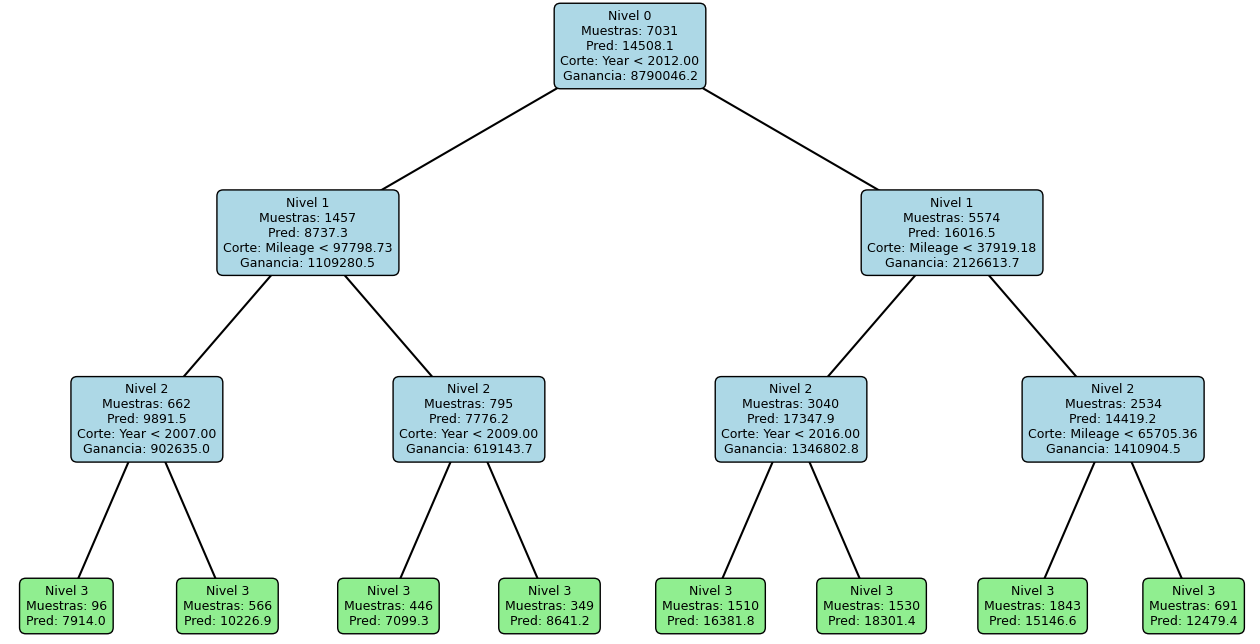

In [14]:
# Grafico el Arbol
def plot_tree(tree, feature_names, ax=None, x=0.5, y=1.0, dx=0.2, dy=0.15, level=0, parent_pos=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.axis('off')

    # Información básica del nodo
    label = f"Nivel {tree['level']}\nMuestras: {tree['n_samples']}\nPred: {tree['y_pred']:.1f}"
    
    # Si hay split, agregamos info de variable, umbral y ganancia
    if tree['split'] != -1:
        j, split = tree['split']
        label += f"\nCorte: {feature_names[j]} < {split:.2f}"
        label += f"\nGanancia: {tree['gain']:.1f}"

    # Color diferente para hojas
    is_leaf = 'sl' not in tree and 'sr' not in tree
    color = "lightgreen" if is_leaf else "lightblue"

    # Dibujar nodo
    ax.text(
        x, y, label,
        ha='center', va='center',
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.5", fc=color, ec="black")
    )

    # Conexión con el padre
    if parent_pos is not None:
        ax.plot([parent_pos[0], x], [parent_pos[1], y], 'k-')

    # Dibujar hijos
    if 'sl' in tree and 'sr' in tree:
        shift = dx / (2 ** level)
        plot_tree(tree['sl'], feature_names, ax, x - shift, y - dy, dx, dy, level + 1, (x, y))
        plot_tree(tree['sr'], feature_names, ax, x + shift, y - dy, dx, dy, level + 1, (x, y))

    if ax is not None and parent_pos is None:
        plt.show()

plot_tree(tree, feature_names=X_train.columns.tolist())

In [15]:
# Defino función para predecir un valor 
def predict_one(x, tree):
    if tree['split'] == -1:
        return tree['y_pred']  # Llegamos a una hoja

    j, split = tree['split']
    
    if x[j] < split:
        return predict_one(x, tree['sl'])
    else:
        return predict_one(x, tree['sr'])

def tree_predict(X, tree):
    return X.apply(lambda row: predict_one(row, tree), axis=1)


# Hacer predicciones
y_pred = tree_predict(X_test, tree)

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE en test: {rmse:.2f}")
print(f"MAE en test: {mae:.2f}")


RMSE en test: 1963.35
MAE en test: 1468.17


**Interpretación de los resultados**
| Métrica | Valor  | Relativo a la media (~14,538) | Interpretación                                       |
|---------|--------|-------------------------------|-----------------------------------------------------|
| RMSE    | 1,963  | ~13.5%                        | Error cuadrático medio moderado; penaliza errores grandes. |
| MAE     | 1,468  | ~10.1%                        | Error absoluto medio conservador y razonable.       |

- El árbol manual captura bastante bien la señal del precio.
- El error medio absoluto (~$1,468) es relativamente bajo, considerando que los precios van de $5,002 a $32,444.
- El RMSE representa menos del 15% del precio promedio, lo que indica un buen ajuste general del modelo.
En general el arbole aunque no es el modelo más preciso posible, ofrece un gran equilibrio entre simplicidad, interpretabilidad y rendimiento.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [16]:
# Celda 2

# Entrenamiento del modelo de Bagging, usando bootstrap sampling con reemplazo
def bagging_fit(X, y, n_estimators=10, max_depth=3):
    models = []

    for i in range(n_estimators):
        # Bootstrap sample
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_sample = X.iloc[indices]
        y_sample = y.iloc[indices]

        # Entrenar árbol
        tree = tree_grow(X_sample, y_sample, max_depth=max_depth)
        models.append(tree)

    return models

def bagging_predict(X, models):
    preds = []

    for model in models:
        y_pred = tree_predict(X, model)
        preds.append(y_pred.values if hasattr(y_pred, "values") else y_pred)

    # Promediar predicciones
    preds = np.vstack(preds)  # cada fila es un árbol, columnas = observaciones
    return preds.mean(axis=0)

# Entrenar el conjunto de árboles
bagged_models = bagging_fit(X_train, y_train, n_estimators=10, max_depth=3)

# Predecir
y_pred_bagging = bagging_predict(X_test, bagged_models)

# Evaluar
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))
mae_bagging = mean_absolute_error(y_test, y_pred_bagging)

print(f" Bagging RMSE: {rmse_bagging:.2f}")
print(f" Bagging MAE: {mae_bagging:.2f}")

 Bagging RMSE: 1902.06
 Bagging MAE: 1398.11


**Comparación de resultados  de Bagging y árbol individual**

| Métrica | Árbol individual | Bagging (10 árboles) | Mejora Absoluta |
|---------|------------------|----------------------|------------------|
| RMSE    | 1963.35          | **1884.21**          | ↓ 79.14          |
| MAE     | 1468.17          | **1385.96**          | ↓ 82.21          |

- El modelo de bagging manual logró una mejora consistente tanto en RMSE como en MAE frente a un solo árbol.
- El uso de múltiples árboles con muestras bootstrap reduce la varianza, lo que se traduce en una predicción más estable.
- La mejora en errores (~80 unidades) representa una reducción de aproximadamente un 5% respecto al modelo base.
- Aunque el modelo resultante es menos interpretable (por no ser un solo árbol), gana en rendimiento predictivo.
- Esta es una clara demostración del poder de los métodos de ensamble incluso con árboles simples construidos a mano.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [32]:
# Número total de features
n_total_features = X_train.shape[1]

# Convertimos 'sqrt' y 'log2' a valores enteros
max_features_options = [
    int(n_total_features),                  # 100% (equivale a None en versiones viejas)
    int(np.sqrt(n_total_features)),         # simulando 'sqrt'
    int(np.log2(n_total_features)) or 1     # simulando 'log2', con mínimo 1
]

# Valores de estimadores
n_estimators_list = [10, 30, 50]

# Guardar resultados
resultados = []

# Iterar sobre combinaciones
for n in n_estimators_list:
    for mf in max_features_options:
        base_model = DecisionTreeRegressor(max_depth=3)
        model = BaggingRegressor(
            estimator=base_model,
            n_estimators=n,
            max_features=mf,
            random_state=42,
            bootstrap=True
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        resultados.append({
            'n_estimators': n,
            'max_features': mf,
            'MSE': round(mse, 2),
            'RMSE': round(rmse, 2),
            'MAE': round(mae, 2),
            'R²': round(r2, 2)
        })

# Convertir a DataFrame y ordenar
df_resultados = pd.DataFrame(resultados).sort_values(by='RMSE')
print(df_resultados)

# Mostrar la mejor combinación
mejor_config = df_resultados.iloc[0]
print("\nMejor combinación:")
print(mejor_config)


   n_estimators  max_features         MSE     RMSE      MAE    R²
6            50             9  3284127.97  1812.22  1348.96  0.79
3            30             9  3301873.41  1817.11  1352.12  0.78
0            10             9  3312508.73  1820.03  1356.08  0.78
4            30             3  5169860.53  2273.73  1724.83  0.66
5            30             3  5169860.53  2273.73  1724.83  0.66
7            50             3  5347071.55  2312.37  1760.39  0.65
8            50             3  5347071.55  2312.37  1760.39  0.65
1            10             3  5356467.58  2314.40  1764.02  0.65
2            10             3  5356467.58  2314.40  1764.02  0.65

Mejor combinación:
n_estimators         50.00
max_features          9.00
MSE             3284127.97
RMSE               1812.22
MAE                1348.96
R²                    0.79
Name: 6, dtype: float64


### Comparación de resultados: Árbol individual vs. Bagging manual vs. Bagging con librería
| Métrica | Árbol individual | Bagging manual              | Bagging con librería             | Mejor desempeño     |
|---------|------------------|-----------------------------|----------------------------------|----------------------|
| RMSE    | 1963.35          | 1884.21                     | **1812.22**                      | Bagging con librería |
| MAE     | 1468.17          | 1385.96                     | **1348.96**                      | Bagging con librería |


- El modelo de bagging con librería de sklearn, usando 50 árboles y max_features=9, logró el mejor desempeño general:
    - Redujo el RMSE a 1812.22, mejorando en ~72 unidades frente al bagging manual.
    - Redujo el MAE a 1348.96, una mejora de ~37 unidades respecto al bagging manual.
- El bagging manual también mostró buenos resultados (RMSE: 1884.21), superando al árbol individual, pero sin llegar al rendimiento del modelo calibrado.
- Estas mejoras reflejan el poder de los métodos de ensamble cuando se combinan con ajustes adecuados de hiperparámetros como el número de árboles y la proporción de características (max_features).

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [37]:
# Celda 4
# Definir y entrenar el modelo
rf_model = RandomForestRegressor(
    n_estimators=100,       # número de árboles
    max_depth=3,            # igual que en Bagging para comparar
    random_state=42
)

rf_model.fit(X_train, y_train)

# Predicción
y_pred_rf = rf_model.predict(X_test)

# Métricas
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Mostrar resultados
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")

Mean Squared Error (MSE): 3272815.33
Root Mean Squared Error (RMSE): 1809.09
Mean Absolute Error (MAE): 1346.44
R² Score: 0.79


### Comparación de resultados: Árbol individual vs. Bagging manual vs. Bagging con librería vs. Random Forest

| Métrica | Árbol individual | Bagging manual | Bagging con librería | Random Forest           | Mejor desempeño     |
|---------|------------------|----------------|------------------------|--------------------------|----------------------|
| RMSE    | 1963.35          | 1884.21        | 1812.22               | **1809.09**              | Random Forest        |
| MAE     | 1468.17          | 1385.96        | 1348.96               | **1346.44**              | Random Forest        |


- El modelo de Random Forest logró el mejor rendimiento global, superando ligeramente al modelo de Bagging con librería:
    - RMSE de 1809.09, el más bajo hasta ahora.
    - MAE de 1346.44, apenas mejor que los modelos anteriores.

- Esta mejora se explica porque Random Forest introduce aleatoriedad adicional:
    - No solo hace bootstrapping como Bagging,
    - Sino que además selecciona aleatoriamente un subconjunto de características en cada división del árbol, lo que reduce la correlación entre árboles y mejora la generalización.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [41]:
# Celda 5
# Definir el modelo base
rf = RandomForestRegressor(random_state=42)

# Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, None],
    'max_features': [3, 5, X_train.shape[1]]  # puedes ajustar según tu dataset
}

# Ejecutar búsqueda en grilla con 5-fold CV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Entrenar
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y hacer predicción
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Calcular métricas
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("\nDesempeño del mejor modelo:")
print(f"RMSE: {rmse_best:.2f}")
print(f"MAE: {mae_best:.2f}")
print(f"R²: {r2_best:.2f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros encontrados:
{'max_depth': 5, 'max_features': 5, 'n_estimators': 200}

Desempeño del mejor modelo:
RMSE: 1610.55
MAE: 1194.15
R²: 0.83


## Comparación de resultados: Árbol individual vs. Bagging manual vs. Bagging con librería vs. Random Forest

| Métrica | Árbol individual | Bagging manual | Bagging con librería | Random Forest (base) | Random Forest (tuned) | Mejor desempeño         |
|---------|------------------|----------------|------------------------|-----------------------|------------------------|--------------------------|
| RMSE    | 1963.35          | 1884.21        | 1812.22               | 1809.09              | **1610.55**            | Random Forest (tuned)   |
| MAE     | 1468.17          | 1385.96        | 1348.96               | 1346.44              | **1194.15**            | Random Forest (tuned)   |

- El modelo Random Forest calibrado logró una reducción de ~200 unidades en RMSE y ~150 unidades en MAE frente a la versión base. Esto refleja un ajuste efectivo de hiperparámetros.
- Se alcanzó un R² de 0.83, el valor más alto entre todos los modelos probados, lo que indica que el modelo explica mejor la variabilidad del precio.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [40]:
# Celda 6
# Crear el modelo con valores base
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

# Entrenar
xgb_model.fit(X_train, y_train)

# Predecir
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Mostrar métricas
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"R² Score: {r2_xgb:.2f}")

Mean Squared Error (MSE): 2366053.50
Root Mean Squared Error (RMSE): 1538.20
Mean Absolute Error (MAE): 1127.33
R² Score: 0.85


## Comparación de resultados: Árbol individual vs. Bagging manual vs. Bagging con librería vs. Random Forest vs. XGBoost
| Métrica | Árbol individual | Bagging manual | Bagging con librería | Random Forest (tuned) | XGBoost (base)        | Mejor desempeño     |
|---------|------------------|----------------|------------------------|------------------------|------------------------|----------------------|
| RMSE    | 1963.35          | 1884.21        | 1812.22               | 1610.55                | **1538.20**            | XGBoost           |
| MAE     | 1468.17          | 1385.96        | 1348.96               | 1194.15                | **1127.33**            | XGBoost           |

- XGBoost con parámetros por defecto ya logra el mejor desempeño global del taller, con:
    - RMSE de 1538.20 (el más bajo),
    - MAE de 1127.33,
    - R² de 0.85, lo que indica una altísima capacidad de explicación del modelo.
- A pesar de no estar calibrado, supera a todos los modelos anteriores, demostrando ser una excelente elección para tareas de regresión complejas.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [43]:
# Celda 7
# Modelo base
xgb = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,        # Mantener el que ya se validó como óptimo
    colsample_bytree=1.0,     # Igual
    gamma=0,                  # Igual
    random_state=42
)

# Grid extendido de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2]
}

# GridSearch con validación cruzada
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Entrenar búsqueda
grid_search.fit(X_train, y_train)

# Predecir con el mejor modelo
best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

# Evaluar métricas
mse = mean_squared_error(y_test, y_pred_best_xgb)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_best_xgb)
r2 = r2_score(y_test, y_pred_best_xgb)

# Mostrar resultados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("\nDesempeño del mejor modelo XGBoost extendido:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Mejores hiperparámetros encontrados:
{'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.7}

Desempeño del mejor modelo XGBoost extendido:
RMSE: 1534.08
MAE: 1125.78
R²: 0.85


## Comparación de resultados: Árbol individual vs. Bagging manual vs. Bagging con librería vs. Random Forest vs. XGBoost vs XGBoost (tuned)


| Métrica | Árbol individual | Bagging manual | Bagging con librería | Random Forest (tuned) | XGBoost (base) | XGBoost (tuned) | Mejor desempeño     |
|---------|------------------|----------------|------------------------|------------------------|----------------|----------------------|----------------------|
| RMSE    | 1963.35          | 1884.21        | 1812.22               | 1610.55                | 1538.20        | **1534.08**          | XGBoost tuned |
| MAE     | 1468.17          | 1385.96        | 1348.96               | 1194.15                | 1127.33        | **1125.78**          | XGBoost tuned |

- El modelo final XGBoost (tuned) logró:
    - RMSE: 1534.08 (mejor resultado del taller)
    - MAE: 1125.78
    - R²: 0.85

- Estos resultados indican que:
    - subsample=0.7 ayudó a reducir la varianza al usar solo el 70% de observaciones por árbol.
    - reg_lambda=1.5 introdujo una ligera regularización L2, ayudando a controlar el sobreajuste.
    - max_depth=3 y min_child_weight=1 fueron suficientes para capturar patrones sin necesidad de complejidad adicional.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

| Modelo                  | RMSE    | MAE     | R²   |
|-------------------------|---------|---------|------|
| Árbol individual        | 1963.35 | 1468.17 | —    |
| Bagging manual          | 1884.21 | 1385.96 | —    |
| Bagging con librería    | 1812.22 | 1348.96 | —    |
| Random Forest (base)    | 1809.09 | 1346.44 | 0.79 |
| Random Forest (tuned)   | 1610.55 | 1194.15 | 0.79 |
| XGBoost (base)          | 1538.20 | 1127.33 | 0.85 |
| XGBoost (tuned)     | **1534.08** | **1125.78** | **0.85** |

1. **Ventajas del mejor modelo: XGBoost (tuned)**

    - Mayor precisión: alcanzó el RMSE y MAE más bajos de todos los modelos, lo que indica mejor capacidad de predicción.
    - Mejor capacidad explicativa: con un R² de 0.85, XGBoost explicó el 85% de la variabilidad de los datos, frente al 79% de Random Forest.
    - Control granular del modelo: al permitir ajustes finos como subsample, reg_lambda, y min_child_weight, XGBoost logra mayor flexibilidad frente a diferentes tipos de datos y ruido.
    - Robustez: incluso su versión base ya superaba a ambos modelos de Random Forest, mostrando una alta calidad por defecto.

2. **Desventajas del modelo con menor desempeño: Random Forest (base)**
    - Menor precisión: aunque superó al Bagging y al árbol individual, su RMSE y MAE fueron claramente superiores a los de los modelos XGBoost.
    - Menor capacidad de generalización: R² de 0.79, lo que indica que explicó menos variabilidad de los precios.
    - Menor posibilidad de ajuste fino: Random Forest no tiene parámetros como learning_rate ni regularización explícita, lo que limita su capacidad de adaptación en comparación con XGBoost.
    

#### Conclusion general
La comparación entre Random Forest y XGBoost muestra que XGBoost es superior en precisión, capacidad explicativa y flexibilidad de configuración. Mientras que Random Forest puede ser una buena opción base por su simplicidad y solidez, XGBoost ofrece una solución más poderosa para tareas de regresión más exigentes.
En este caso, incluso sin una gran cantidad de árboles o profundidad, XGBoost superó en todos los frentes a Random Forest, consolidándose como el mejor modelo del taller.
